# Fetch SurfaceGrid bulk data from DSIS

This notebook demonstrates how to fetch and decode **SurfaceGrid** binary (protobuf) data from DSIS using the `dsis-client` library.

The following steps are covered:

1. Authenticate to DSIS using an `.env` file with the required configuration and credentials.
2. Construct and execute a query requesting surface grid metadata.
3. Fetch binary bulk data for a specific surface grid using `get_bulk_data()` and `get_bulk_data_stream()`.
4. Decode the protobuf response (LGCStructure) and visualise the result.

For more information about the required content of the `.env` file, please contact the SDD-SID team, or the DSIS team in Equinor.

In [40]:
from dotenv import load_dotenv
import os
import json

from dsis_client import DSISClient, DSISConfig, QueryBuilder, Environment

### Authenticate and connect to DSIS

We need to specify the name of the model we plan to use, as the `dsis-client` library requires this when building the `DSISConfig` object.

In [41]:
MODEL_NAME = "OpenWorksCommonModel"

Next, we provide all the other required configuration and credentials via the `.env` file. Make sure to modify the `config` logic below if you are, e.g., fetching secrets from a key vault through this notebook.

In [42]:
load_dotenv(".env_dsis")

True

In [43]:
config = DSISConfig(
    environment=Environment.DEV,
    tenant_id=os.getenv("tenant_id"),
    client_id=os.getenv("client_id"),
    client_secret=os.getenv("client_secret"),
    access_app_id=os.getenv("resource_id"),
    dsis_username=os.getenv("dsis_function_key"),
    dsis_password=os.getenv("dsis_password"),
    subscription_key_dsauth=os.getenv("subscription_key_dsauth"),
    subscription_key_dsdata=os.getenv("subscription_key_dsdata"),
    dsis_site=os.getenv("dsis_site"),
)

In [44]:
dsis_client = DSISClient(config)
if dsis_client.test_connection():
    print("✓ Connected to DSIS API")

✓ Connected to DSIS API


### Build and execute a query

Specify the OW database (district), project, and schema.

In [45]:
SCHEMA = "SurfaceGrid"
DISTRICT = "BG4FROST"
PROJECT = "VOLVE_PUBLIC"

In [46]:
# Helper function which might be incorporated in the dsis-client library in the future


def build_district_id(database: str, *, model_name: str) -> str:
    """Build DSIS district_id from database name.

    DSIS uses different district-id conventions for different models.

    Examples:
    - OpenWorksCommonModel: OpenWorksCommonModel_OW_<DB>-OW_<DB>
    - OpenWorks native models (e.g., OW5000): OpenWorks_OW_<DB>_SingleSource-OW_<DB>
    """
    if model_name == "OpenWorksCommonModel":
        return f"OpenWorksCommonModel_OW_{database}-OW_{database}"
    return f"OpenWorks_OW_{database}_SingleSource-OW_{database}"

Build a query specifying the district (OW database), project, and schema (DSIS endpoint exposed in the model selected earlier).

In [47]:
query = QueryBuilder(
    model_name=MODEL_NAME,
    district_id=build_district_id(DISTRICT, model_name=MODEL_NAME),
    project=PROJECT,
).schema(SCHEMA)

Execute the query and inspect the first surface grid returned.

In [48]:
query_results = list(dsis_client.execute_query(query))

In [49]:
query_results[0].keys()

dict_keys(['odata.mediaReadLink', 'odata.mediaEditLink', 'odata.mediaContentType', 'data_values@odata.mediaEditLink', 'data_values@odata.mediaReadLink', 'data_values@odata.mediaContentType', 'map_data_set_name', 'z_unit_type', 'fault_set_type', 'rotation_unit', 'z_unit', 'remark', 'y_max', 'x_min', 'update_user_id', 'xy_unit', 'z_domain_qualifier', 'data_domain', 'num_rows', 'y_min', 'data_min', 'x_max', 'attribute', 'alternate_uid', 'create_date', 'create_user_id', 'geo_type', 'geologic_feature', 'native_uid', 'data_null_value', 'rotation_origin_y', 'crs', 'rotation_origin_x', 'data_max', 'num_cols', 'data_source', 'update_date', 'grid_interval_x', 'rotation_j', 'rotation_i', 'grid_interval_y', 'geo_name'])

In [50]:
print(json.dumps(query_results[0], indent=4))

{
    "odata.mediaReadLink": "SurfaceGrid('2636')/$value",
    "odata.mediaEditLink": "SurfaceGrid('2636')",
    "odata.mediaContentType": "application/octet-stream",
    "data_values@odata.mediaEditLink": "SurfaceGrid('2636')/data_values",
    "data_values@odata.mediaReadLink": "SurfaceGrid('2636')/data_values",
    "data_values@odata.mediaContentType": "application/octet-stream",
    "map_data_set_name": "ihdTHugin13flt3",
    "z_unit_type": "depth measure",
    "fault_set_type": null,
    "rotation_unit": "rad",
    "z_unit": "meters",
    "remark": null,
    "y_max": "6482747.0",
    "x_min": "429588.0",
    "update_user_id": null,
    "xy_unit": "meters",
    "z_domain_qualifier": null,
    "data_domain": "TVDSS",
    "num_rows": 629,
    "y_min": "6475211.0",
    "data_min": -3502.0696,
    "x_max": "440124.0",
    "attribute": "DEPTH",
    "alternate_uid": "{\"geo_name\":\"UNKNOWN\",\"geo_type\":\"SURFACE\",\"map_data_set_name\":\"ihdTHugin13flt3\",\"attribute\":\"DEPTH\",\"data

### Fetch bulk (binary) data

The `dsis-client` provides two methods for downloading binary protobuf data:

- **`get_bulk_data()`** – loads everything at once (best for < 100 MB)
- **`get_bulk_data_stream()`** – streams in chunks (best for > 100 MB)

Use `query.entity(native_uid, data_field=...)` to target a specific entity's binary data, then pass the query to the bulk-data method.

> **Note:** SurfaceGrid uses the `/$value` endpoint, so we pass `data_field="$value"`.

First, we define a helper to decode the LGCStructure protobuf into a 2-D NumPy array.

In [51]:
import numpy as np


def decode_surfacegrid(data: bytes, n_rows: int, n_cols: int) -> np.ndarray:
    """Decode SurfaceGrid binary data (LGCStructure) into a 2-D numpy array.

    Each LGC element represents one grid column. The element *name* is the
    column index and the element's ``data_float`` field contains ``n_rows``
    values.  Null sentinels (≥ 1 × 10³⁰) are replaced with NaN.
    """
    from dsis_model_sdk.protobuf import decode_lgc_structure

    lgc = decode_lgc_structure(data, skip_length_prefix=True)

    grid = np.full((n_rows, n_cols), np.nan, dtype=np.float64)
    for el in lgc.elements:
        if len(el.data_float) == n_rows and el.elementName.lstrip("-").isdigit():
            col = int(el.elementName)
            if 0 <= col < n_cols:
                grid[:, col] = np.array(el.data_float, dtype=np.float64)

    # Mask protobuf null sentinels (OpenWorks uses large values for "non-interpreted")
    grid[np.abs(grid) >= 1.0e30] = np.nan

    return grid

#### Method 1: `get_bulk_data()` — load everything at once

Best for small to medium datasets (< 100 MB). We already configured `bulk_query` with `query.entity(uid, data_field="$value")` — just pass it to `get_bulk_data()`.

In [52]:
uid = query_results[0]["native_uid"]
print(f"Fetching bulk data for native_uid: {uid}")

# Target the entity's binary data field via query.entity()
bulk_query = query.entity(uid, data_field="$value")

Fetching bulk data for native_uid: 2636


In [53]:
# Fetch all bulk data at once
binary_data = dsis_client.get_bulk_data(bulk_query, accept="application/octet-stream")

if binary_data:
    print(f"Downloaded {len(binary_data):,} bytes")
else:
    print("No bulk data available for this entity")

Downloaded 2,773,141 bytes


### Decode and visualise

Decode the LGCStructure protobuf into a 2-D NumPy array and plot the grid using metadata (dimensions, spatial extent, rotation) from the query result.

Grid: UNKNOWN  (629×879, dx=12.0, dy=12.0)
Coverage: 552,891 / 552,891 (100.0%)
Value range: [-3502.07, -2649.91]  Mean: -3107.06


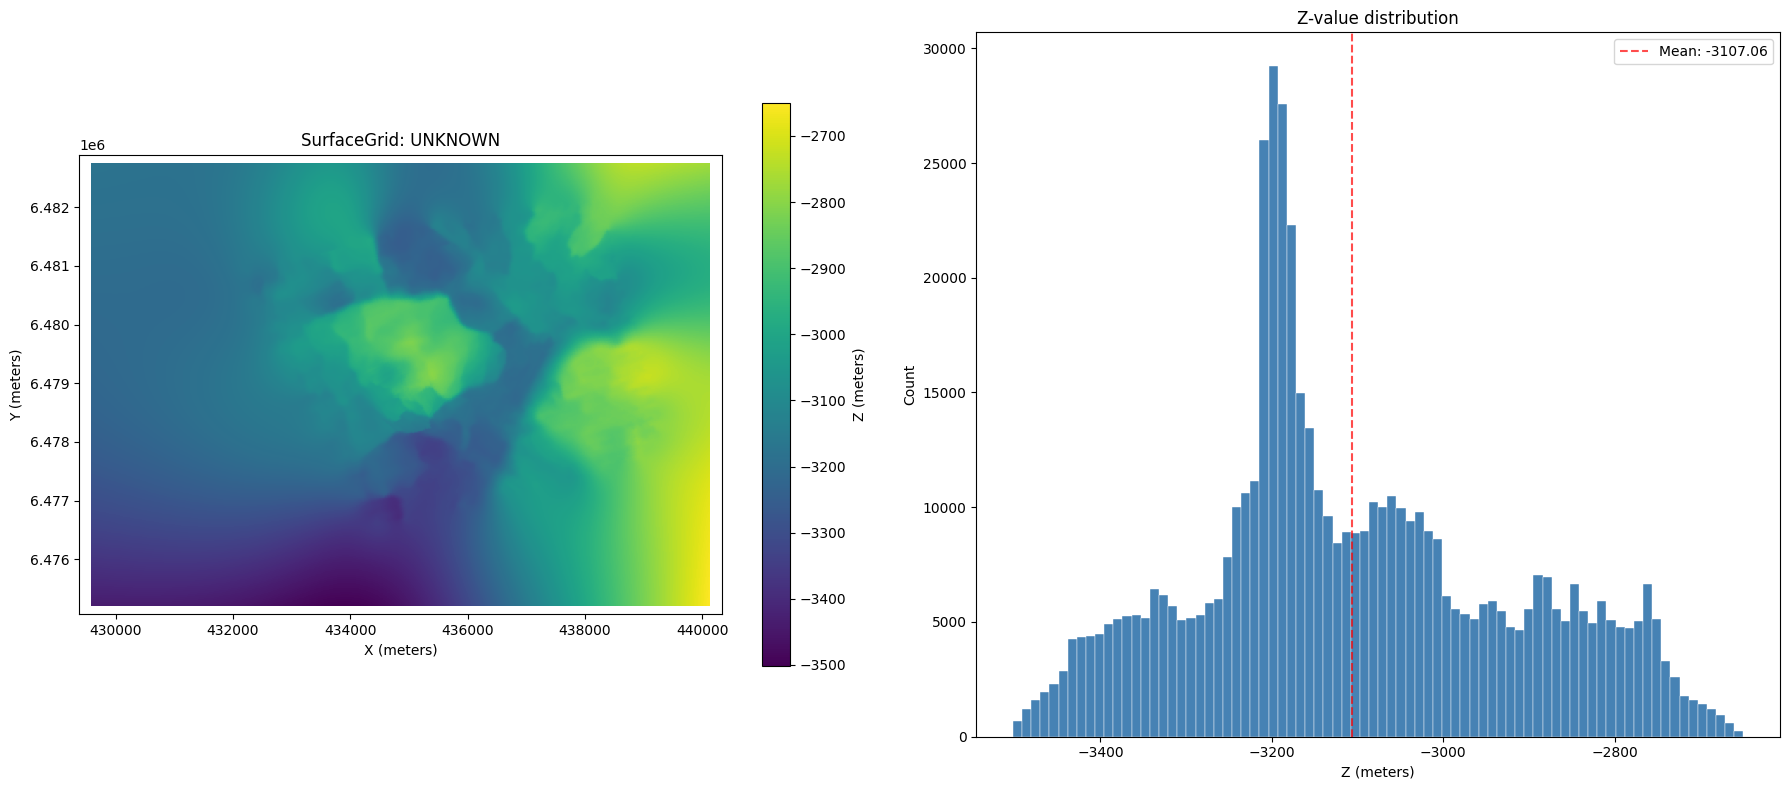

In [54]:
import matplotlib.pyplot as plt

# ── Extract grid metadata from the query result ─────────────────────────
meta = query_results[0]
n_rows = int(meta["num_rows"])
n_cols = int(meta["num_cols"])
x_min = float(meta["x_min"])
y_min = float(meta["y_min"])
dx = float(meta["grid_interval_x"])
dy = float(meta["grid_interval_y"])
null_val = float(meta["data_null_value"]) if meta.get("data_null_value") else None
rot_i = float(meta.get("rotation_i") or 0)
rot_j = float(meta.get("rotation_j") or 0)
rot_ox = float(meta.get("rotation_origin_x") or 0)
rot_oy = float(meta.get("rotation_origin_y") or 0)
z_unit = meta.get("z_unit", "")
xy_unit = meta.get("xy_unit", "")
grid_name = meta.get("geo_name") or meta.get("map_data_set_name") or uid

print(f"Grid: {grid_name}  ({n_rows}×{n_cols}, dx={dx}, dy={dy})")

# ── Decode binary data to 2-D numpy array ───────────────────────────────
z_grid = decode_surfacegrid(binary_data, n_rows, n_cols)

# Also mask the metadata-declared null value
if null_val is not None:
    z_grid[z_grid == null_val] = np.nan

valid = z_grid[~np.isnan(z_grid)]
print(
    f"Coverage: {len(valid):,} / {z_grid.size:,} ({len(valid) / z_grid.size * 100:.1f}%)"
)
if len(valid) > 0:
    print(
        f"Value range: [{np.min(valid):.2f}, {np.max(valid):.2f}]  Mean: {np.mean(valid):.2f}"
    )

# ── Build real-world coordinates with rotation ──────────────────────────
j_idx, i_idx = np.meshgrid(np.arange(n_cols), np.arange(n_rows))

local_x = x_min + j_idx * dx - rot_ox
local_y = y_min + i_idx * dy - rot_oy

theta = np.radians(rot_i)
world_x = rot_ox + local_x * np.cos(theta) - local_y * np.sin(theta)
world_y = rot_oy + local_x * np.sin(theta) + local_y * np.cos(theta)

# ── Crop axes to the bounding box of non-NaN data ──────────────────────
data_mask = ~np.isnan(z_grid)
data_rows, data_cols = np.where(data_mask)
if len(data_rows) > 0:
    wx = world_x[data_mask]
    wy = world_y[data_mask]
    pad_x = (wx.max() - wx.min()) * 0.02
    pad_y = (wy.max() - wy.min()) * 0.02
    xlim = (wx.min() - pad_x, wx.max() + pad_x)
    ylim = (wy.min() - pad_y, wy.max() + pad_y)

# ── Plot ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

if rot_i == 0 and rot_j == 0:
    extent = [x_min, x_min + n_cols * dx, y_min, y_min + n_rows * dy]
    im = axes[0].imshow(
        z_grid, cmap="viridis", aspect="equal", origin="lower", extent=extent
    )
else:
    im = axes[0].pcolormesh(world_x, world_y, z_grid, cmap="viridis", shading="auto")
    axes[0].set_aspect("equal")

# Zoom to actual data extent
if len(data_rows) > 0:
    axes[0].set_xlim(xlim)
    axes[0].set_ylim(ylim)

axes[0].set_title(f"SurfaceGrid: {grid_name}")
axes[0].set_xlabel(f"X ({xy_unit})")
axes[0].set_ylabel(f"Y ({xy_unit})")
fig.colorbar(im, ax=axes[0], label=f"Z ({z_unit})", shrink=0.8)

if len(valid) > 0:
    axes[1].hist(valid, bins=80, color="steelblue", edgecolor="white", linewidth=0.3)
    axes[1].set_title("Z-value distribution")
    axes[1].set_xlabel(f"Z ({z_unit})")
    axes[1].set_ylabel("Count")
    axes[1].axvline(
        np.mean(valid),
        color="red",
        linestyle="--",
        alpha=0.7,
        label=f"Mean: {np.mean(valid):.2f}",
    )
    axes[1].legend()

plt.tight_layout()
plt.show()

#### Method 2: `get_bulk_data_stream()` — stream in chunks

Best for large datasets (> 100 MB). Data is yielded in chunks so the full response never has to fit in memory at once.

In [ ]:
# Stream bulk data in chunks (memory-efficient for large datasets)
chunks: list[bytes] = []
for chunk in dsis_client.get_bulk_data_stream(
    bulk_query,
    chunk_size=10 * 1024 * 1024,  # 10 MB per chunk
    accept="application/octet-stream",
):
    chunks.append(chunk)
    print(f"  Received chunk: {len(chunk):,} bytes")

if chunks:
    streamed_data = b"".join(chunks)
    print(f"\nTotal downloaded: {len(streamed_data):,} bytes")

    z_streamed = decode_surfacegrid(streamed_data, n_rows, n_cols)
    match = np.array_equal(np.nan_to_num(z_grid), np.nan_to_num(z_streamed))
    print(f"Matches non-streamed: {match}")
else:
    print("No bulk data returned")